In [55]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
data = fio.read(catalog_path)
catalog_cluster = data[data['LOC'] == 1]
catalog_field = data[data['LOC'] == 0]

In [72]:
galpath = "./ICL/evolving_red_gal.dat"
mstarpath = "./ICL/mstar_des_i03.fit"
jk_profile_root = "./ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [3]:
catalog = np.hstack((catalog_cluster, catalog_field))

In [73]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

In [7]:
ims_cluster = []

for band in ["g", "r", "i"]:
    df = render.DrawField(5000, catalog_cluster, band=band)
    df.prepare()
    df.make_infodicts()
    df.multi_render(100)
    df.collate_stamps()
    ims_cluster.append(df.canvas.array)

starting xshear calculations in 100 processes
starting xshear calculations in 100 processes
starting xshear calculations in 100 processes


In [8]:
ims_field = []
for band in ["g", "r", "i"]:
    df = render.DrawField(5000, catalog_field, band=band)
    df.prepare()
    df.make_infodicts()
    df.multi_render(100)
    df.collate_stamps()
    ims_field.append(df.canvas.array)

starting xshear calculations in 100 processes
starting xshear calculations in 100 processes
starting xshear calculations in 100 processes


In [9]:
ims_all = []
for band in ["g", "r", "i"]:
    df = render.DrawField(5000, catalog, band=band)
    df.prepare()
    df.make_infodicts()
    df.multi_render(100)
    df.collate_stamps()
    ims_all.append(df.canvas.array)

starting xshear calculations in 100 processes
starting xshear calculations in 100 processes
starting xshear calculations in 100 processes


In [28]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
noises = [
    np.random.normal(scale=stds[0], size=(5000, 5000)),
    np.random.normal(scale=stds[1], size=(5000, 5000)),
    np.random.normal(scale=stds[2], size=(5000, 5000)),
    np.random.normal(scale=stds[3], size=(5000, 5000)),
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9451932907104492


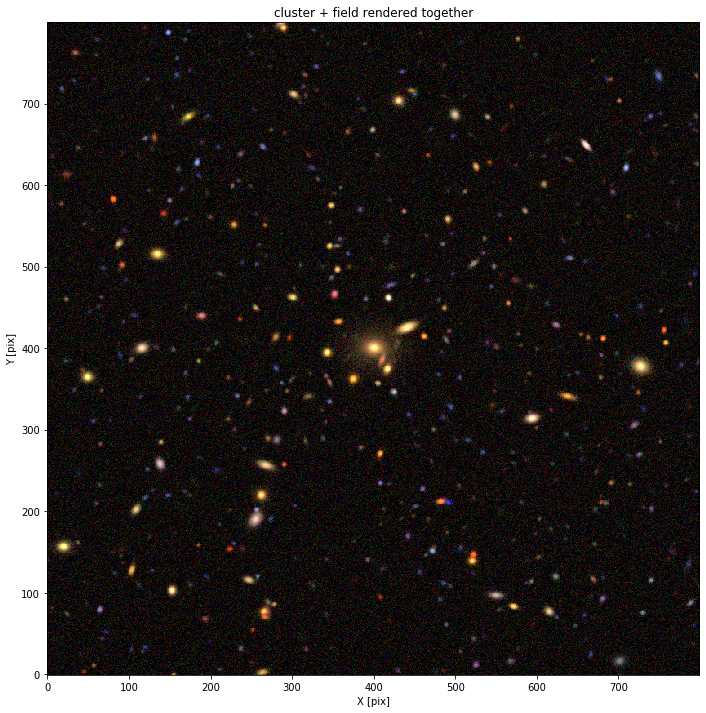

In [88]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + ims_icl[2] + noises[2] + pad,
                                ims_all[1] + ims_icl[1] + noises[1] + pad,
                                ims_all[0] + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2100:2900, 2100:2900] * 2, origin=3)

ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("all_01.png", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9451432228088379


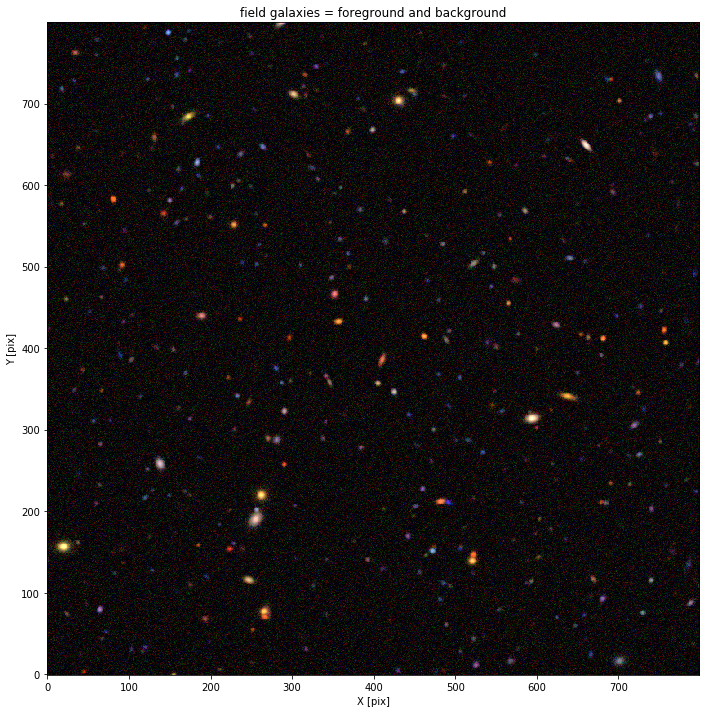

In [75]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_field[2] + noises[2] + pad,
                                ims_field[1] + noises[1] + pad,
                                ims_field[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2100:2900, 2100:2900] * 2, origin=3)

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
ax.set_title("field galaxies = foreground and background")
fig.savefig("field_foreground+background_01.png", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8063381314277649


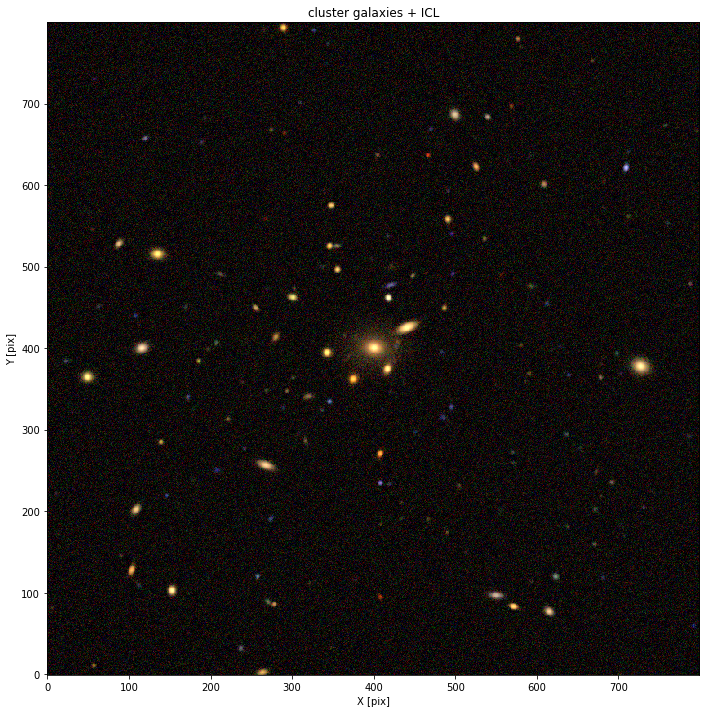

In [76]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_cluster[2] + ims_icl[2] + noises[2] + pad,
                                ims_cluster[1] + ims_icl[1] + noises[1] + pad,
                                ims_cluster[0] + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2100:2900, 2100:2900] * 2, origin=3)

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
ax.set_title("cluster galaxies + ICL")
fig.savefig("cluster+ICL_01.png", bbox_inches='tight')

In [40]:
catalog_field_back = catalog_field[catalog_field['Z'] > 0.325]

In [42]:
catalog_field_back.shape

(9037,)

# Postage Stamps

In [46]:
dfc = render.DrawField(5000, catalog_cluster, band='i')
dfc.prepare()
dfc.make_infodicts()
dfc.multi_render(100)
dfc.collate_stamps()

starting xshear calculations in 100 processes


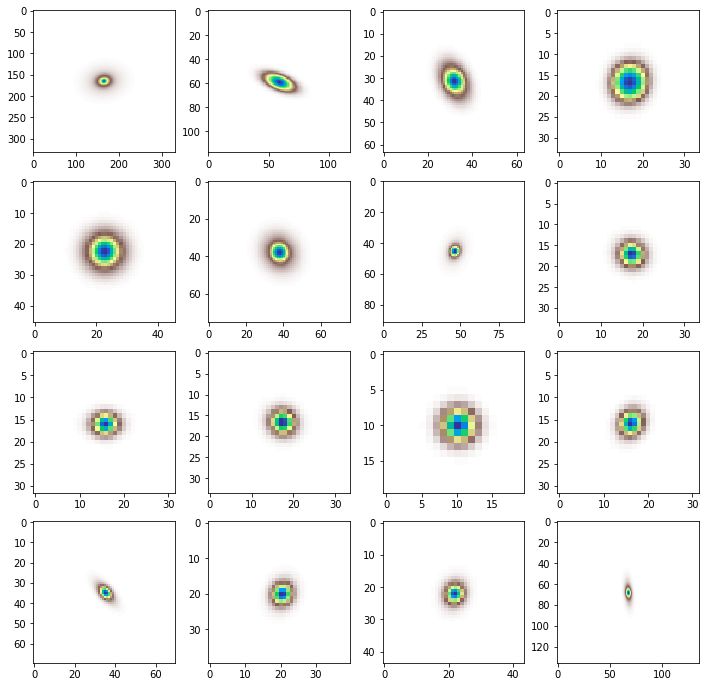

In [87]:
fig, axarr = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axarr.flatten()):
    cc = dfc.stamps[i].array
    ax.imshow(images.asinh_scale(cc*0.01, 0.12) * 2, cmap=plt.cm.terrain_r,
              norm=mpl.colors.Normalize())

#     ax.imshow()
fig.savefig("postage_stamps_01.png", bbox_inches='tight')

In [78]:
ims_cluster_bcg = []

for band in ["g", "r", "i"]:
    df = render.DrawField(5000, catalog_cluster[:1], band=band)
    df.prepare()
    df.make_infodicts()
    df.multi_render(100)
    df.collate_stamps()
    ims_cluster_bcg.append(df.canvas.array)

starting xshear calculations in 1 processes
starting xshear calculations in 1 processes
starting xshear calculations in 1 processes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7748863101005554


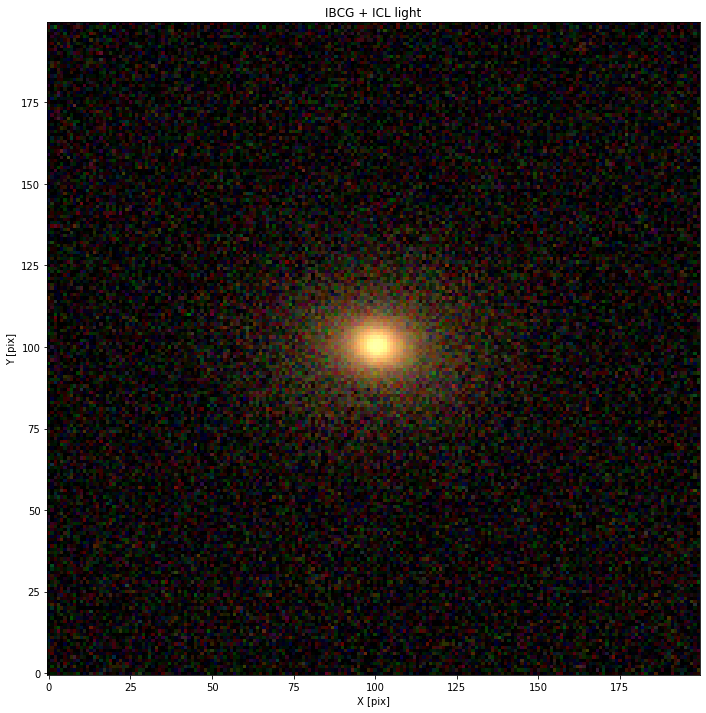

In [86]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_cluster_bcg[2] + ims_icl[2] + noises[2] + pad,
                                ims_cluster_bcg[1] + ims_icl[1] + noises[1] + pad,
                                ims_cluster_bcg[0] + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin=3)
ax.set_title("IBCG + ICL light")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("bcg+ICL_01.png", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7745983600616455


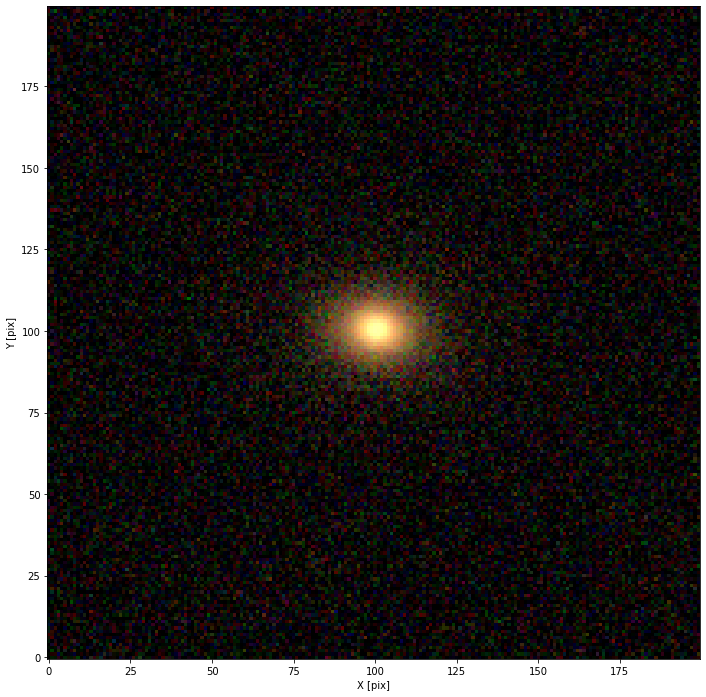

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_cluster_bcg[2] + noises[2] + pad,
                                ims_cluster_bcg[1] + noises[1] + pad,
                                ims_cluster_bcg[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin=3)
ax.set_title("Bright Cluster Galaxy light model")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("bcg_01.png", bbox_inches='tight')

0.3139168620109558


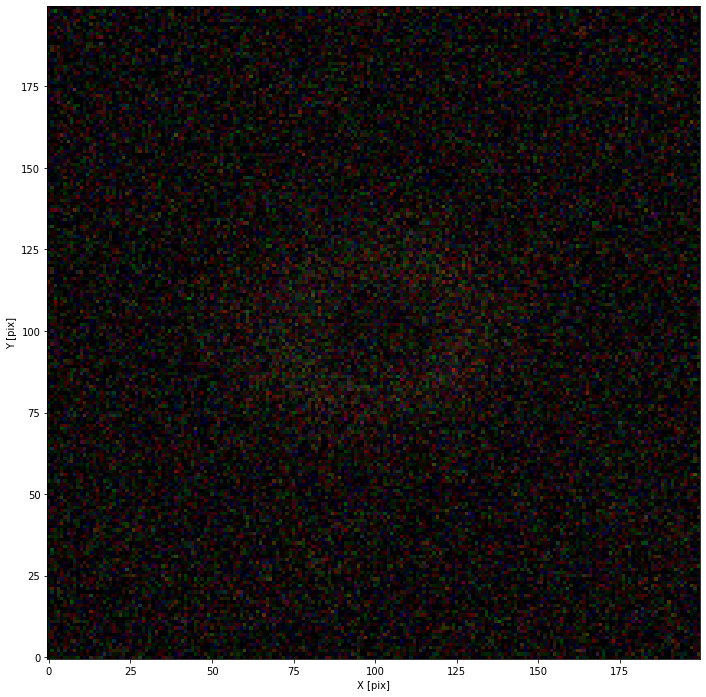

In [85]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_icl[2] + noises[2] + pad,
                                ims_icl[1] + noises[1] + pad,
                                ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin=3)
ax.set_title("Intra Cluster Light (excluding the BCG regime)")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("ICL_01.png", bbox_inches='tight')

# 

In [92]:
class ExtractShear(object):
    def __init__(self, drawer):
        self.drawer = drawer
        self.raw_stamps = self.drawer.stamps
        self.image_epsf = self.drawer.image_epsf
        self.BADVAL = -9999
        
    def extract_stamps(self, size=32):
        self.stamps = []
        
        half_size = size // 2
        
        for i, stamp in enumerate(self.raw_stamps):
            bounds = stamp.bounds
            cen = bounds.center
            bb = galsim.bounds.BoundsI(cen.x - half_size,
                                       cen.x + half_size - 1,
                                       cen.y - half_size,
                                       cen.y + half_size - 1)
            self.stamps.append(self.drawer.canvas[bb])
    
    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
        stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)
        

In [118]:
tcat = catalog
tcat['G1'][tcat['Z'] > 0.4] = 0.05
tcat['G2'][tcat['Z'] > 0.4] = -0.03

tcat['G1'][tcat['Z'] < 0.4] = -0.02
tcat['G2'][tcat['Z'] < 0.4] = 0.02

In [119]:
df = render.DrawField(5000, tcat, band="i")
df.prepare()
df.make_infodicts()
df.multi_render(100)
df.collate_stamps()

starting xshear calculations in 100 processes


In [120]:
noise = np.random.normal(scale=stds[2] / 2, size=(5000, 5000))


In [121]:
df.add_icl(noise)

In [122]:
es = ExtractShear(df)
es.extract_stamps()
es.estimate_shear(sky_var=stds[2] / 2, shear_est="KSB")

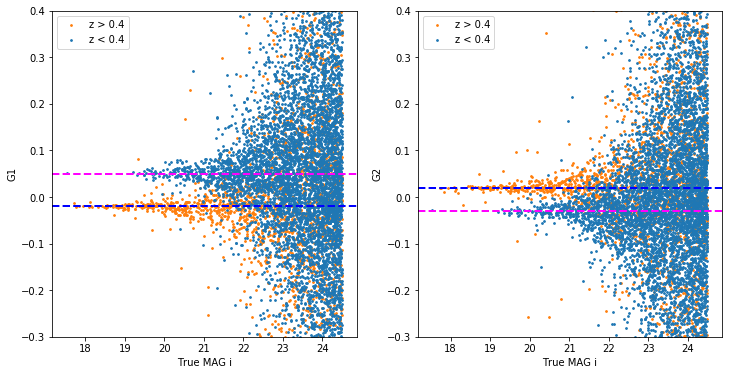

In [132]:
fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))



ax = axarr[0]
# ax.set_title("each galaxy has the same shape, different sizes and mags")
ii1 = (tcat['Z'] < 0.4) * es.success
ii2 = (tcat['Z'] > 0.4) * es.success

val1 = catalog["MAG_I"][ii1]
val2 = es.shears[ii1, 0]
ax.scatter(val1, val2, color="C1", s=3, label="z > 0.4")

val1 = catalog["MAG_I"][ii2]
val2 = es.shears[ii2, 0]
ax.scatter(val1, val2, color="C0", s=3, label="z < 0.4")
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(0.05, color="magenta", ls="--", lw=2)
ax.axhline(-0.02, color="blue", ls="--", lw=2)
ax.set_ylabel("G1")
ax.legend()

ax = axarr[1]
ii1 = (tcat['Z'] < 0.4) * es.success
ii2 = (tcat['Z'] > 0.4) * es.success

val1 = catalog["MAG_I"][ii1]
val2 = es.shears[ii1, 1]
ax.scatter(val1, val2, color="C1", s=3, label="z > 0.4")

val1 = catalog["MAG_I"][ii2]
val2 = es.shears[ii2, 1]
ax.scatter(val1, val2, color="C0", s=3, label="z < 0.4")
# ax.set_yscale("log")
ax.set_ylim(-0.3, 0.4)
ax.set_xlabel("True MAG i")
ax.axhline(-0.03, color="magenta", ls="--", lw=2)
ax.axhline(0.02, color="blue", ls="--", lw=2)
ax.set_ylabel("G1")
ax.legend()
ax.set_ylabel("G2")

fig.savefig("sheared_bacground_01.png", bbox_inches="tight")

In [133]:
class ExtractShear(object):
    def __init__(self, drawer):
        self.drawer = drawer
        self.raw_stamps = self.drawer.stamps
        self.image_epsf = self.drawer.image_epsf
        self.BADVAL = -9999
        
    def extract_stamps(self, size=32):
        self.stamps = []
        
        half_size = size // 2
        
        for i, stamp in enumerate(self.raw_stamps):
            bounds = stamp.bounds
            cen = bounds.center
            bb = galsim.bounds.BoundsI(cen.x - half_size,
                                       cen.x + half_size - 1,
                                       cen.y - half_size,
                                       cen.y + half_size - 1)
            self.stamps.append(self.drawer.canvas[bb])
    
    def estimate_shear(self, sky_var=0, shear_est="KSB", which="canvas"):
        """
        shear modes = REGAUSS’, ‘LINEAR’, ‘BJ’, or ‘KSB’
        which is raw or canvas, default to canvas
        """
        
        stamps = self.raw_stamps
        if which == "canvas":
            stamps = self.stamps
        
        self.logs = []
        self.shears = []
        self.success = []
        self.fluxes = []
        self.shears_error = []
        for i, im in enumerate(stamps):
            try:
                res = galsim.hsm.EstimateShear(im, self.image_epsf, shear_est=shear_est, sky_var=sky_var)
                self.logs.append(res)
                
                tmp = np.array([res.corrected_g1, res.corrected_g2])
                
                self.shears.append(tmp)
                self.fluxes.append(res.moments_amp * (self.drawer.pixel_scale)**2)
                self.shears_error.append(res.corrected_shape_err)
                self.success.append(True)
#                 print("here")
            except:
                self.logs.append(None)
                self.fluxes.append(None)
                tmp = np.array([self.BADVAL, self.BADVAL])
                self.shears.append(tmp)
                self.shears_error.append(None)
                self.success.append(False)
                
                
               
        self.fluxes = np.array(self.fluxes)
        self.shears = np.array(self.shears)
        self.success = np.array(self.success)
        self.shears_error = np.array(self.shears_error)
        